

> Данное задание посвещено востановлению искаженных изображений. На примере размытых и зашумленных изображений мы научимся использовать простейшие методы: 
*   Инверсная фильтрация
*   Винеровская фильтрация





## Введение

Мы будем рассматривать востановление размытых изображений, но рассматриваемые методы могут быть применимы и к другим видам искажения. Может показаться, что размытие необратимая операция и информация безвозвратно теряется, т.к. каждый пиксель превращается в пятно, все смешивается, а при большом радиусе размытия так и вовсе получим однородный цвет по всему изображению. Но это не совсем так – вся информация просто перераспределяется по некоторому закону. В этом задании мы познакомимся с тем, как ее можно восстановить. 

Визуально наша задача выглядит следующем образом:

![Востановление изображения](source/images/restoring.png)

## Модель процесса искажения

Теперь формализуем процесс искажения. Для удобства будем рассматривать только полутоновые черно-белые изображения в предположении, что для обработки полноцветного изображения достаточно повторить все необходимые шаги для каждого из цветовых каналов RGB. 

Модель процесса искажения предполагает действие некоторого искажающего оператора $H$ на исходное изображение $f(x, y)$, что после добавления аддитивного шума дает искаженное изображение $g(x, y)$.

Задача восстановления состоит в построении некоторого приближения $\tilde{f} (x, y)$ исходного изображения по заданному (искаженному) изображению $g(x, y)$, некоторой информации относительно искажающего оператора $H$ и некоторой информации относительно аддитивного шума $η(x, y)$. 

Схематически процесс искажения-восстановления можно изобразить так:

![Искажение-Восстановление](source/images/model.png)



Таким образом получим следующую модель получения искаженного изображения:

> $g(x, y) = h(x, y) * f(x, y) + n(x, y)$ (1),   где

* $f(x, y)$ – исходное неискаженное изображение <br>
* $h(x, y)$ – искажающая функция <br>
* $n(x, y)$ – аддитивный шум <br>
* $g(x, y)$ – результат искажения, т.е. то, что мы наблюдаем в результате (расфокусированное изображение) <br>

\* - операция свертки в пространственной области:<br>

![Операция свертки !h](source/images/conv.png)




## Искажающая функция

Как уже говорилось ранее, мы сосредоточимся только на восстановлении размытых изображений. В таких случаях в роли искажающей функции $h$ выступает фильтр Гаусса.

Функция Гаусса: 
> $G(r)=\frac{1}{2\pi\sigma^2}e^{-\frac{r^2}{2\sigma^2}}$, 
где $r=\sqrt{(x-x_0)^2 + (y-y_0)^2}$, $x_0, y_0$ -- центр фильтра








> **Задание 1** (1 балл) <br>
Реализуйте функцию, возвращающую ядро фильтра Гаусса заданного размера и с заданным значением параметра $\sigma$.



In [1]:
import numpy as np

def G_kernel(size, sigma):
    """
    Построение ядра фильтра Гаусса.
    
    @param  size  int    размер фильтра
    @param  sigma float  параметр размытия
    @return numpy array  фильтр Гаусса размером size x size      
    """

    x0 = size // 2
    y0 = size // 2
    
    x = np.arange(0, size, dtype=float)
    y = np.arange(0, size, dtype=float)[:,np.newaxis]
    x -= x0
    y -= y0
    
    exp_part = (x**2 + y**2) / (2 * sigma**2)
    gaussian = 1 / (2 * np.pi * sigma**2) * np.exp(-exp_part)

    return gaussian / np.sum(gaussian)

In [3]:
# Тесты
from source.tests import test_gaussian
test_gaussian(G_kernel)

---------------
OK, + 1 балл


Выглядит процесс размытия следующим образом:

![Размытие фильтром Гаусса](source/images/blure_proc.png)

## Переход в частотную область. Теорема о свертке.

Вернемся теперь к первоначальной постановке задачи восстановления - нам необходимо каким-то образом обратить свертку. Делать это "в лоб" довольно затратно из-за сложности операции свертки. Для упрощения задача преобразуется в так называемую частотную область, где работа идет не с самими изображениями и искажающими функциями, а с их Фурье-образами. Корректность перехода обуславливается *теоремой о свертке*, которую можно сформулировать следующим образом:


> **Теорема о свертке**:  Свертка в пространственной области аналогична умножению в частотной области, т.е.: $h(x,y) * f(x,y) <=> H(u, v)F(u, v)$,   где H(u, v) и F(u,v) -- Фурье-образы h(x, y) и f(x, y) соотоветсвенно.

Получим, что задающее модель равенство (1) может быть эквивалентным образом записано в частотной области:



>$G(u, v) = H(u, v) F(u,v) + N(u, v)$  (2),   

где обозначенные заглавными буквами функции суть Фурье-образы соответствующих функций в (1), а умножение не матричное, а поэлементное.

## Инверсная фильтрация

Простейшим способом восстановления является инверсная фильтрация, которая предполагает получение оценки $\tilde{F}(u, v)$ Фурье-преобразования исходного изображения делением Фурье-преобразования искаженного изображения на частотное представление искажающей функции:


> $\tilde{F}(u, v) = \frac{G(u, v)}{H(u, v)}  (3)$

Деление здесь понимается как поэлементное.

Подставив правую часть выражения (2) для $G(u,v)$ в (3), получим оценку:


> $\tilde{F}(u, v) = F(u, v) + \frac{N(u,v)}{H(u, v)}$ (4)

Из 4 видно, что даже зная искажающую функцию $H$ при наличии шума невозможно точно восстановить исходное изображение (так как $N(u, v)$ неизвестна). Поэтому инверсную фильтрацию обычно использует при отсутсвии шума (в таком случае удается точно восстановить изображение).

Имеется и еще одна проблема. Если функция H(u,v) принимает нулевые или близкие к нулевым значения, то вклад второго слагаемого
в правой части (4) может стать доминирующим. Эта
ситуация часто реализуется на практике.

Последнюю проблему можно решить, отсеив близкие к $0$ значения $H(u, v)$. Что позволит улучшить метод инверсной фильтрации при наличие шума. Тогда можно переписать (3) в виде:

> $\tilde F(u, v) = G(u,v)  H_{inv}(u,v)$  (5), где <br><br>
$H_{inv}(u, v) = \begin{cases} 0, & \mbox{if  }  |H(u, v)| \mbox{ < threshold} \\ \frac{1}{H(u,v)}, & \mbox{otherwise}  \end{cases}$


Но стоит понимать, что расматриваемый метод никак не учитывает наличие и характеристики шума, поэтому на хорошее приближении исходного изображение можно надеется только при условии отсутсвия шума.







Обратите внимания, что искажающая матрица зачастую имеет размерность меньше размерности изображения, но размерности их Фурье-образов должны совпадать.

> **Задание 2** (0.5 баллов) <br>
Реализуйте функцию, возвращающую Фурье-образ искажающей функции заданного размера.

In [4]:
def get_H(h, shape):
    """
    Получение Фурье-образа искажающей функции
    
    @param  h            numpy array   искажающая функция (ядро свертки)
    @param  shape        list          требуемый размер образа
    @return numpy array  Фурье-образ h      
    """
    
    h_padded = np.zeros(shape) 
    h_padded[:h.shape[0], :h.shape[1]] = np.copy(h)
    H = np.fft.fft2(h_padded)
    return H

In [5]:
# Тут предполагаются тесты
from source.tests import test_H
test_H(get_H)

---------------
OK, + 0.5 баллов


> **Задание 3** (0.5 баллов) <br>
Реализуйте функцию, по известному $H$ возвращающую $H_{inv}$.

In [6]:
def inv(H, threshold=1e-10):
    """
    Получение H_inv
    
    @param  size         int    фурье-образ искажающей функции
    @param  threshold    float  порог отсечения для избежания деления на 0
    @return numpy array  H_inv    
    """
    
    M = np.zeros(H.shape)
    M[np.abs(H) > threshold] = 1

    H1 = H.copy()
    H1[np.abs(H1) <= threshold] = 1
    return M / H1

In [7]:
# Тесты 
from source.tests import test_inv
test_inv(inv)

---------------
OK, + 0.5 баллов


Чтобы получить восстановленное изображение по $\tilde{F}$ нужно перейти обратно в пространственную область, воспользовавшись обратным преобразованием Фурье.

> **Задание 4** (1 балл) <br>
Реализуйте метод инверсной фильтрации в форме (5).

In [8]:
def invere_filtering(blure_img, h, threshold=1e-10):
    """
    Метод инверсной фильтрации
    
    @param  blure_img    numpy array  скаженное изображение
    @param  h            numpy array  искажающая функция
    @param  threshold    float        параметр получения H_inv
    @return numpy array  востановленное изображение   
    """

    G = np.fft.fft2(blure_img)
    H = get_H(h, blure_img.shape)
    F = G * inv(H, threshold)
    f = np.fft.ifft2(F)
    return np.abs(f)

In [9]:
# Тесты 
from source.tests import test_if
test_if(invere_filtering)

---------------
OK, + 1 балл


**Пример**.<br>
Картинка была размыта фильтром Гаусса размерности 15 со значением $\sigma=5$. Шум отсутсвует. 

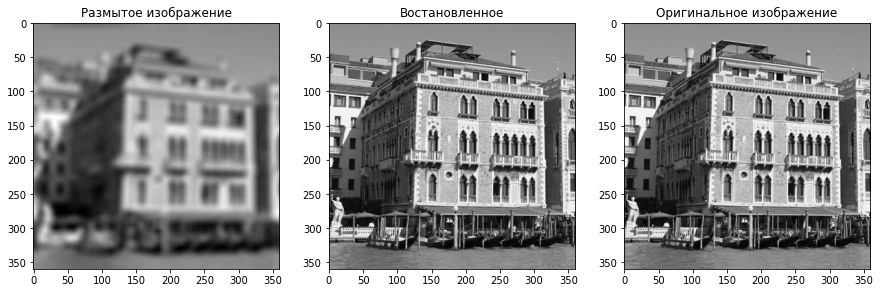

In [10]:
# Запустите ячейку, чтобы посмотреть как восстановилось изображение.

import matplotlib.pyplot as plt

blured = np.load('source/examples/blured.npy')
original = np.load('source/examples/original.npy')

kernel = G_kernel(size=15, sigma=5)
restored = invere_filtering(blured, kernel)

plt.figure(figsize=(15,10))
t = ["Размытое изображение", "Востановленное", "Оригинальное изображение"]
columns = 3

images = [blured, restored, original]
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(t[i])

**Пример**.<br>
Влияния шума на метод инверсной фильтрации. 

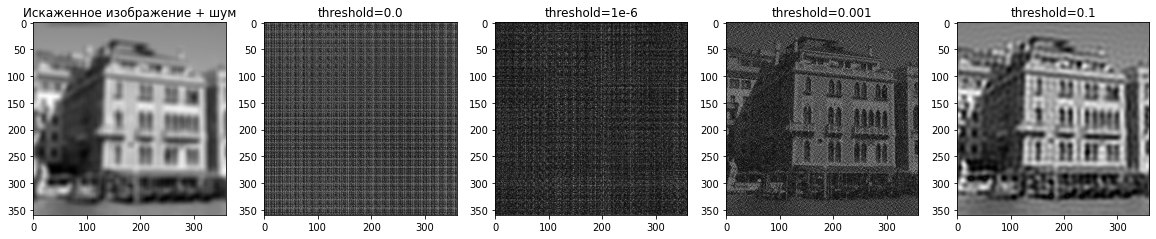

In [10]:
# Запустите ячейку, чтобы посмотреть пример.
import matplotlib.pyplot as plt

noisy_img = np.load('source/examples/noisy.npy')
kernel = G_kernel(size=15, sigma=5)

plt.figure(figsize=(20,10))
t = ["Искаженное изображение + шум", "threshold=0.0", "threshold=1e-6", "threshold=0.001", "threshold=0.1"]
columns = 5

ths = [0.0, 1e-6, 1e-3, 0.1]
restored = [invere_filtering(noisy_img, kernel, threshold=th) for th in ths]
images = [noisy_img] + restored
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(t[i])

## Винеровская фильтрация

Следующий метод обеспечивает более корректную работы с зашумленными изображениями.  Винеровский метод основан на рассмотрении изображений и шума как случайных переменных, и задача ставится следующим образом: найти такую оценку $\tilde{f}$ для неискаженного
изображения $f$, чтобы средний квадрат отклонения этих величин друг от друга
(ошибка) было минимальным. То есть, стоит задачи минимизации величины:


> $e^2 = E\{ (f - \tilde{f})^2\}$  (6),

где $E\{.\}$ - математическое ожидание своего аргумента.

Будем считать, что выполнены следующие условия: 
1.   Шум и неискаженное изображение не коррелированы между собой;
2.   Либо шум, либо неискаженное изображение
имеют нулевое среднее значение;
3.   Оценка линейно зависит от искаженного
изображения.


Тогда минимум среднего квадрата отклонения (6) достигается на функции, которая задается в частотной области выражением:


> $\tilde{F}(u, v) = (\frac{H(u,v)^*}{|H(u,v)|^2 + S_η(u,v) / S_f(u,v)})G(u, v)$  (7), где

* $H(u,v)$ — искажающая функция (ее частотное представление);
* $H^*(u,v)$ — комплексное сопряжение $H(u,v)$;
* $|H(u,v)|^2= H^*(u,v)H(u,v)$;
* $S_η(u,v)$ — энергетический спектр шума;
* $S_f(u,v)$ — энергетический спектр неискаженного изображения;
* $S_η(u,v) / S_f(u,v)$ — число, которое прибавляется ко всем элементам |H(u,v)|^2;
* Деления здесь поэлементное. Каждый элмент матрицы-числителя делится на соответсвующий элемент матрицы-знаменателя.




Приведенный результат был получен Н. Винером [N. Wiener, 1942], и метод известен
как оптимальная фильтрация по Винеру. Фильтр, представленный выражением внутри скобок, часто называют фильтром минимального среднеквадратического отклонения или винеровским фильтром. 


В тех случаях, когда спектры шума и неискаженного изображения неизвестны и не могут быть оценены, часто используется подход, состоящий в аппроксимации выражения (7) выражением:

> $\tilde{F}(u, v) = (\frac{H(u,v)^*}{|H(u,v)|^2 + K})G(u, v)$  (8),

где K — определенная константа, прибавляемая ко всем значениям $|H(u,v)|^2$. Деление поэлементное. Мы далее будем использовать именно это выражение.



> **Задание 5** (1 балл) <br>
Реализуйте метод оптимальной фильтрации по Винеру ( выражение (8) ).

In [11]:
def wiener_filtering(blure_img, h, K):
    """
    Винеровская фильтрация
    
    @param  blure_img    numpy array  искаженное изображение
    @param  h            numpy array  искажающая функция
    @param  K            float        константа из выражения (8)
    @return numpy array  востановленное изображение   
    """

    G = np.fft.fft2(blure_img)
    H = get_H(h, blure_img.shape)
    F = np.conj(H) / (np.abs(H) ** 2 + K) * G
    restored = np.abs(np.fft.ifft2(F))
    return restored

In [12]:
# Тесты
from source.tests import test_wf
test_wf(wiener_filtering)

---------------
OK, + 1 балл


### Оценка качества восстановления 

Будем рассматривать восстановленное изображение как
сигнал, а разницу между ним и исходным — как шум. Чем ближе востановленное изображение к исходному, тем выше значение метрики PSNR (Peak signal-to-noise ratio).



> $PSNR = 20 * log_{10} (\frac{MAX_I}{\sqrt{MSE}})$, 

где 
* $MAX_I$ является максимально возможным значением пикселя изображения (в 8-ми битном формате это 255).
* $MSE$ - mean squared error.








> **Задание 6** (0.5 баллов) <br>
Реализуйте метрику PSNR.

In [13]:
def compute_psnr(img1, img2):
    """
    PSNR metric
    
    @param  img1    numpy array   оригинальное изображение
    @param  img2    numpy array   искаженное изображение
    @return float   PSNR(img1, img2)   
    """
    img1 = np.array(img1, dtype=np.float32)
    img2 = np.array(img2, dtype=np.float32)
    
    mse = np.mean((img1 - img2) ** 2) 
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse)) 
    return psnr 

In [14]:
# Тесты
from source.tests import test_psnr
test_psnr(compute_psnr)

---------------
OK, + 0.5 баллов


> **Задание 7** (0.5 баллов) <br>
Подберите константу сигнал/шум (K в выражение 8) и примените метод Венеровской фильтрации. 

**Дано**: изображение, размытое фильтром Гаусса размера 15 с парметром $\sigma = 5$. В процессе размытия к изображению был добавлен Гауссовский шум. 

**Требуется**: подобрать параметр К и, применив фильтр Винера, восстановить изображение. 

Задание считается выполненным, если значение метрики PSNR увеличится хотя бы на 7 пунктов по сравнению с неотфильтрованным изображением.

In [15]:
img = np.load('source/examples/original.npy')
blurred_img = np.load('source/examples/blured.npy')
noisy_img = np.load('source/examples/noisy.npy')
kernel = G_kernel(size=15, sigma=5)

In [16]:
# Укажите K
K = 0.00006 
filtered_img = wiener_filtering(noisy_img, kernel, K)

In [17]:
# Тесты
from source.tests import test_wf_2
test_wf_2(filtered_img, compute_psnr)

---------------
OK, + 0.5 баллов


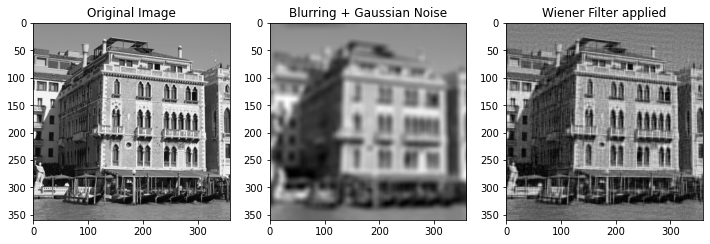

In [18]:
#Запустите ячейку, чтобы посмотреть как восстановилось изображение.

display = [img, noisy_img, filtered_img]
label = ['Original Image', 'Blurring + Gaussian Noise', 'Wiener Filter applied']

fig = plt.figure(figsize=(12, 10))

for i in range(len(display)):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(display[i], cmap = 'gray')
    plt.title(label[i])

plt.show()

## Литература

1. Гонсалес Р., Вудс Р. Цифровая обработка изображений
2. Восстановление расфокусированных и смазанных изображений (https://habr.com/ru/post/136853/)